# Create and train MitoSplit-Net model

## Import required Python libraries



In [1]:
import util
import plotting
import training

import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
from tqdm import tqdm

import tensorflow as tf

In [2]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Import and reshape data 

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


## Create model

In [5]:
model = training.create_model()

NameError: name 'training' is not defined

## Split dataset and train

In [6]:
with gpu:
  history, frames_test = training.train_model(model, input_data, output_data)
  model_path = base_dir + 'Models/f8_c9_b8/'
  model.save(model_path+'ref_model.h5')
  util.save_pkl(history, model_path, 'history')
  util.save_pkl(frames_test, model_path, 'frames_test')

Epoch 1/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.2004 - binary_accuracy: 0.9691 - val_loss: -0.4048 - val_binary_accuracy: 0.9820
Epoch 2/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.4705 - binary_accuracy: 0.9812 - val_loss: -0.5080 - val_binary_accuracy: 0.9853
Epoch 3/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.5524 - binary_accuracy: 0.9845 - val_loss: -0.5706 - val_binary_accuracy: 0.9891
Epoch 4/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.5999 - binary_accuracy: 0.9866 - val_loss: -0.6010 - val_binary_accuracy: 0.9831
Epoch 5/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.6294 - binary_accuracy: 0.9878 - val_loss: -0.6166 - val_binary_accuracy: 0.9872
Epoch 6/20
1480/1480 [==============================] - 29s 20ms/step - loss: -0.6544 - binary_accuracy: 0.9889 - val_loss: -0.6090 - val_binary_accuracy: 0.9822
Epoch 7/20
1480/1480 [======

Saving H:/Santi/Models/ref_model/f8_c9_b16/history
Done.
Saving H:/Santi/Models/ref_model/f8_c9_b16/frames_test
Done.


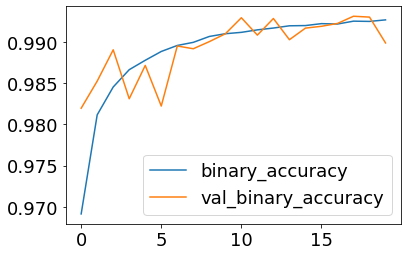

In [8]:
metric = 'binary_accuracy'
plt.plot(history[metric], label=metric)
plt.plot(history['val_'+metric], label='val_'+metric)
plt.legend()
plt.show()